# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 2021-03-31

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import typing

plt.rcParams["figure.figsize"] = (20,15)
_FONTSIZE=20

# Initial data management
_DATADIR="_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2021-03-31.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"]) # set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

 # Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# compare day on day increments/deltas
def get_daily_delta(df: pd.DataFrame, col: str) -> typing.List[int]:
    """
    Returns list containing daily reported cases
    """
    daily_delta_column = []
    reported = df[col]
    for i in range(0,len(reported)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(
            reported.iloc[i]-reported.iloc[i-1]
        )

    return daily_delta_column

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name()) # create new column for day of week
cumul_ams["Day"].astype("str")
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.isocalendar().week) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns), "Year", cumul_ams["Date_of_report"].dt.isocalendar().year) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns),"Daily_delta",get_daily_delta(cumul_ams, "Total_reported")) # add daily delta of total reported to df
cumul_ams.insert(len(cumul_ams.columns),"Deceased_delta",get_daily_delta(cumul_ams, "Deceased")) # add daily delta of total deceased to df
cumul_ams.insert(len(cumul_ams.columns),"Hospital_delta",get_daily_delta(cumul_ams, "Hospital_admission")) # add daily delta of total hospitalized to df

/Users/zeddee/src/nl-covid19-eda/.direnv/python-3.9.2/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Get only the data we want from dataframe

In [2]:
# create working df with: date, cumulative day of week, week number, reports
cumuldf = cumul_ams[
    ["Date_of_report","Day","Week","Year","Daily_delta", "Total_reported", "Deceased", "Deceased_delta", "Hospital_admission", "Hospital_delta"]
]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384 entries, 109 to 140418
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      384 non-null    datetime64[ns]
 1   Day                 384 non-null    object        
 2   Week                384 non-null    UInt32        
 3   Year                384 non-null    UInt32        
 4   Daily_delta         384 non-null    int64         
 5   Total_reported      384 non-null    int64         
 6   Deceased            384 non-null    int64         
 7   Deceased_delta      384 non-null    int64         
 8   Hospital_admission  384 non-null    int64         
 9   Hospital_delta      384 non-null    int64         
dtypes: UInt32(2), datetime64[ns](1), int64(6), object(1)
memory usage: 30.8+ KB


### Data from last 10 days

In [3]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Year,Daily_delta,Total_reported,Deceased,Deceased_delta,Hospital_admission,Hospital_delta
137142,2021-03-22,Monday,12,2021,228,68439,705,0,1670,5
137506,2021-03-23,Tuesday,12,2021,225,68664,709,4,1673,3
137870,2021-03-24,Wednesday,12,2021,300,68964,709,0,1677,4
138234,2021-03-25,Thursday,12,2021,306,69270,709,0,1682,5
138598,2021-03-26,Friday,12,2021,340,69610,710,1,1683,1
138962,2021-03-27,Saturday,12,2021,385,69995,714,4,1690,7
139326,2021-03-28,Sunday,12,2021,303,70298,715,1,1695,5
139690,2021-03-29,Monday,13,2021,366,70664,715,0,1696,1
140054,2021-03-30,Tuesday,13,2021,217,70881,717,2,1702,6
140418,2021-03-31,Wednesday,13,2021,299,71180,720,3,1705,3


### Top 10 days (reported cases)

In [4]:
sorted_df = cumuldf[["Date_of_report","Week","Daily_delta","Total_reported","Hospital_delta"]].sort_values(by="Daily_delta",ascending=False)
sorted_df.head(10)

,Date_of_report,Week,Daily_delta,Total_reported,Hospital_delta
83051,2020-10-25,43,831,27273,8
81950,2020-10-22,43,813,25191,14
81583,2020-10-21,43,751,24378,7
82317,2020-10-23,43,745,25936,14
78647,2020-10-13,42,734,19163,16
80482,2020-10-18,42,726,22398,7
81216,2020-10-20,43,696,23627,3
80115,2020-10-17,42,687,21672,19
83785,2020-10-27,44,686,28485,6
79748,2020-10-16,42,682,20985,7


In [5]:
def get_week_start_end(df:pd.DataFrame, week_number:int)->typing.Tuple[str,str]:
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df:pd.DataFrame, n:int=3, year:int=2021):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart
    """
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.xlabel("Day of week", fontsize=_FONTSIZE)
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5), fontsize=_FONTSIZE)
    plt.ylabel("Daily change", fontsize=_FONTSIZE)

    for week in range(0,n):

        df = df[df["Year"] == year]
        today = df["Date_of_report"].max()
        this_week_number = pd.Timestamp(today).week - week
        # we previously tried to get the week number by getting
        # the max value of df["Week"] (the week column),
        # but that breaks when we move from one year to the next
        # now, get week from the latest report.
        this_week = df[df["Week"] == this_week_number]
        last_week = df[df["Week"] == this_week_number-1]

        x_range = ["(Sunday before)"]+this_week["Day"].to_list()
        including_last_sunday = [last_week["Daily_delta"].to_list()[-1]]+this_week["Daily_delta"].to_list()
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(x_range,including_last_sunday,label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend(fontsize=_FONTSIZE)

### Plot daily reported cases, by week

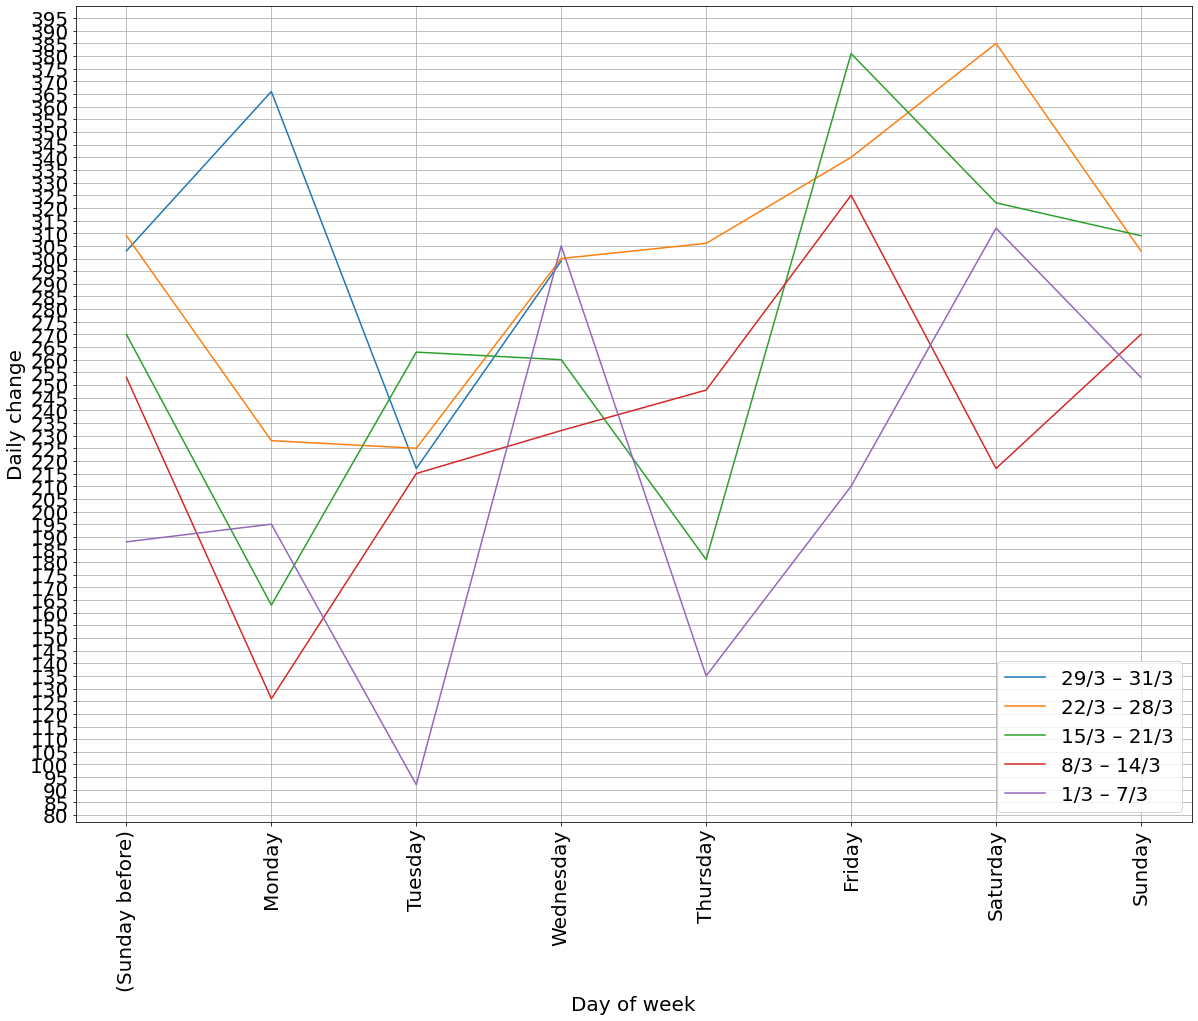

,Date_of_report,Week,Daily_delta,Total_reported
138234,2021-03-25,12,306,69270
138598,2021-03-26,12,340,69610
138962,2021-03-27,12,385,69995
139326,2021-03-28,12,303,70298
139690,2021-03-29,13,366,70664
140054,2021-03-30,13,217,70881
140418,2021-03-31,13,299,71180


In [6]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [7]:
def plot_weekly_delta_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,int]:
    """
    Returns a dict containing weekly delta for the last n weeks,
    like: {"Week n": int,"Week n-1": int, ...}
    """

    weekly_delta = {}
    for week in range(0,n):
        this_week = pd.Timestamp(df["Date_of_report"].max()).week
        if this_week < week:
            print(f"Week no. {this_week - week} does not exist.")
            continue

        this_week_num = this_week - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week reported cases

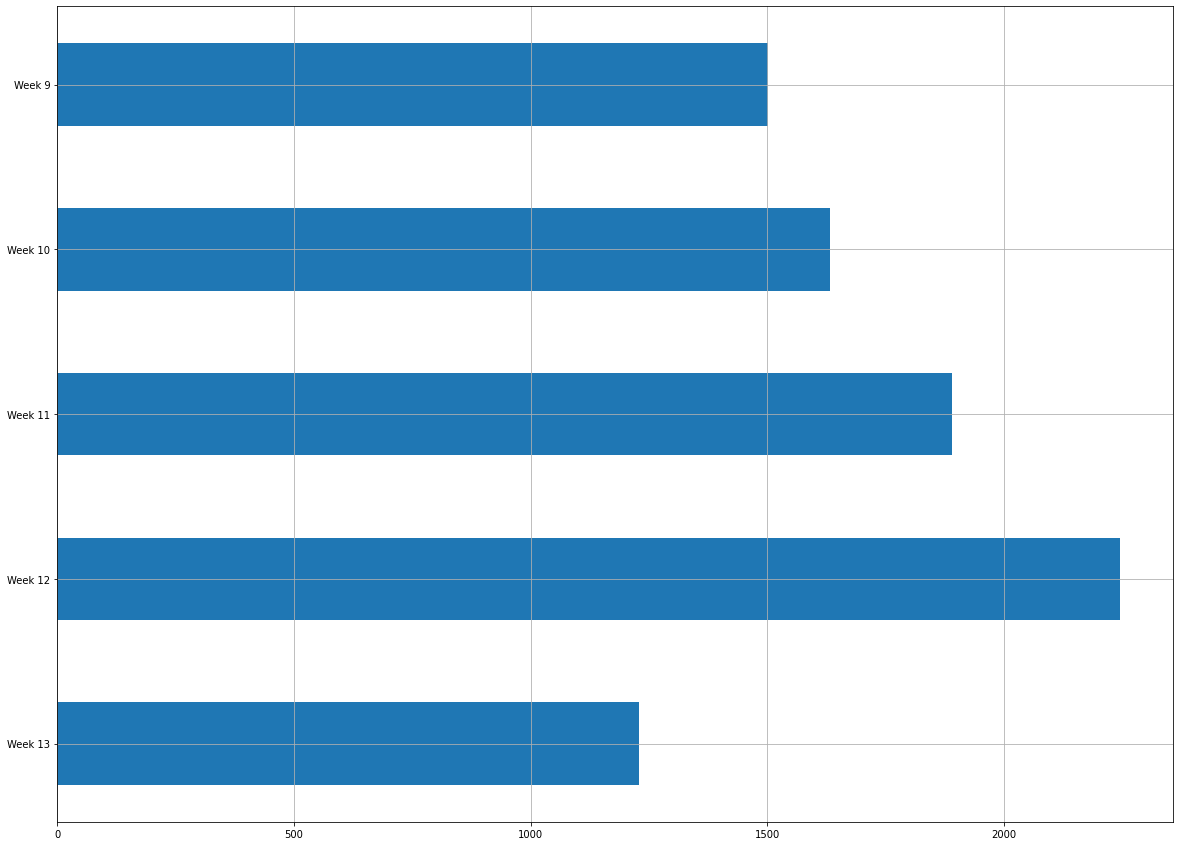

{'Week 10': 1633,
 'Week 11': 1890,
 'Week 12': 2246,
 'Week 13': 1230,
 'Week 9': 1502}


In [8]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [9]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df:pd.DataFrame,n:int=3, col:str="Total_reported") -> None:
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.yticks(plot_this[col], fontsize=_FONTSIZE)
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this[col],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", col]].tail(n))

### Cumulative reported cases for the last 30 days

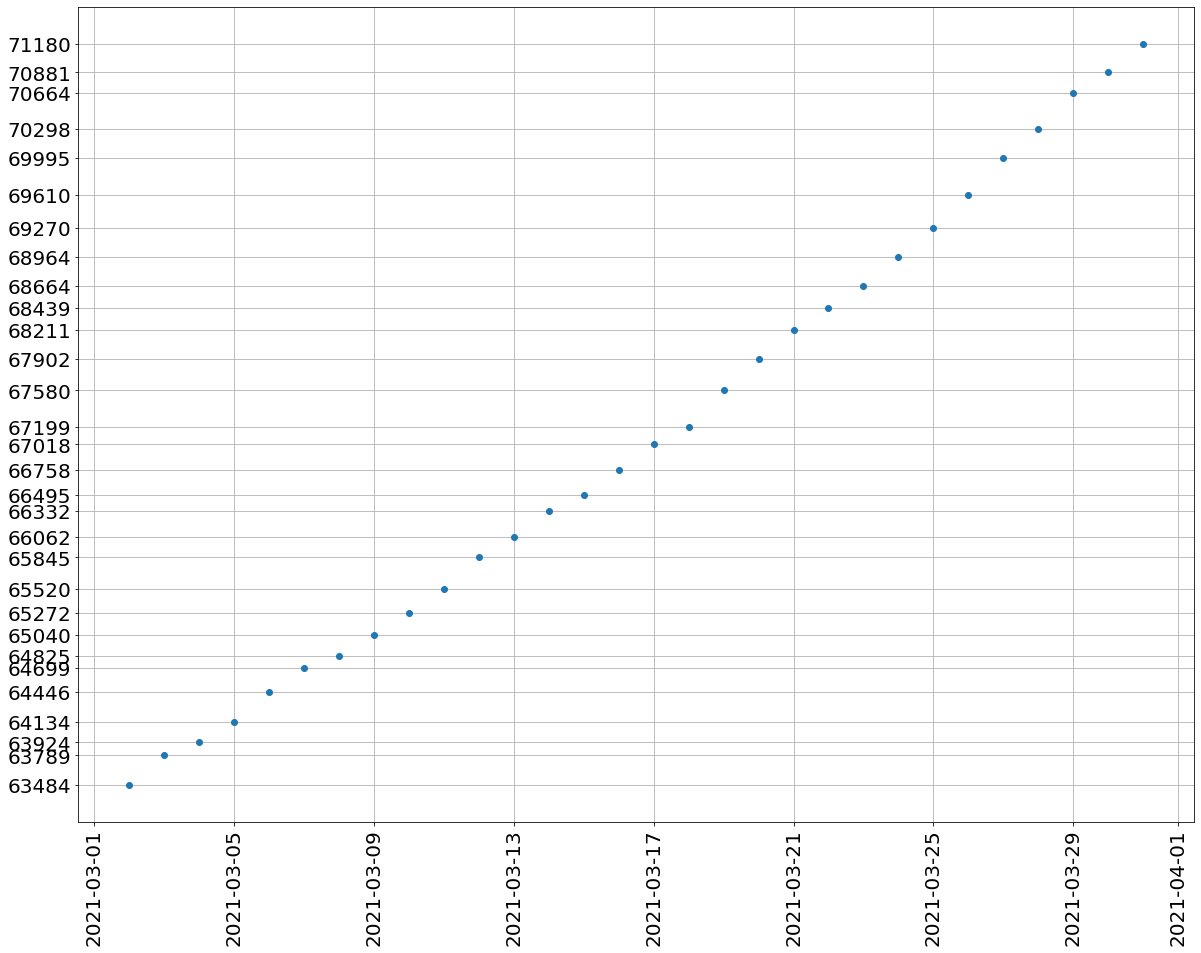

       Date_of_report  Total_reported
129862     2021-03-02           63484
130226     2021-03-03           63789
130590     2021-03-04           63924
130954     2021-03-05           64134
131318     2021-03-06           64446
131682     2021-03-07           64699
132046     2021-03-08           64825
132410     2021-03-09           65040
132774     2021-03-10           65272
133138     2021-03-11           65520
133502     2021-03-12           65845
133866     2021-03-13           66062
134230     2021-03-14           66332
134594     2021-03-15           66495
134958     2021-03-16           66758
135322     2021-03-17           67018
135686     2021-03-18           67199
136050     2021-03-19           67580
136414     2021-03-20           67902
136778     2021-03-21           68211
137142     2021-03-22           68439
137506     2021-03-23           68664
137870     2021-03-24           68964
138234     2021-03-25           69270
138598     2021-03-26           69610
138962     2

In [10]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Total_reported")

### Cumulative reported cases since beginning

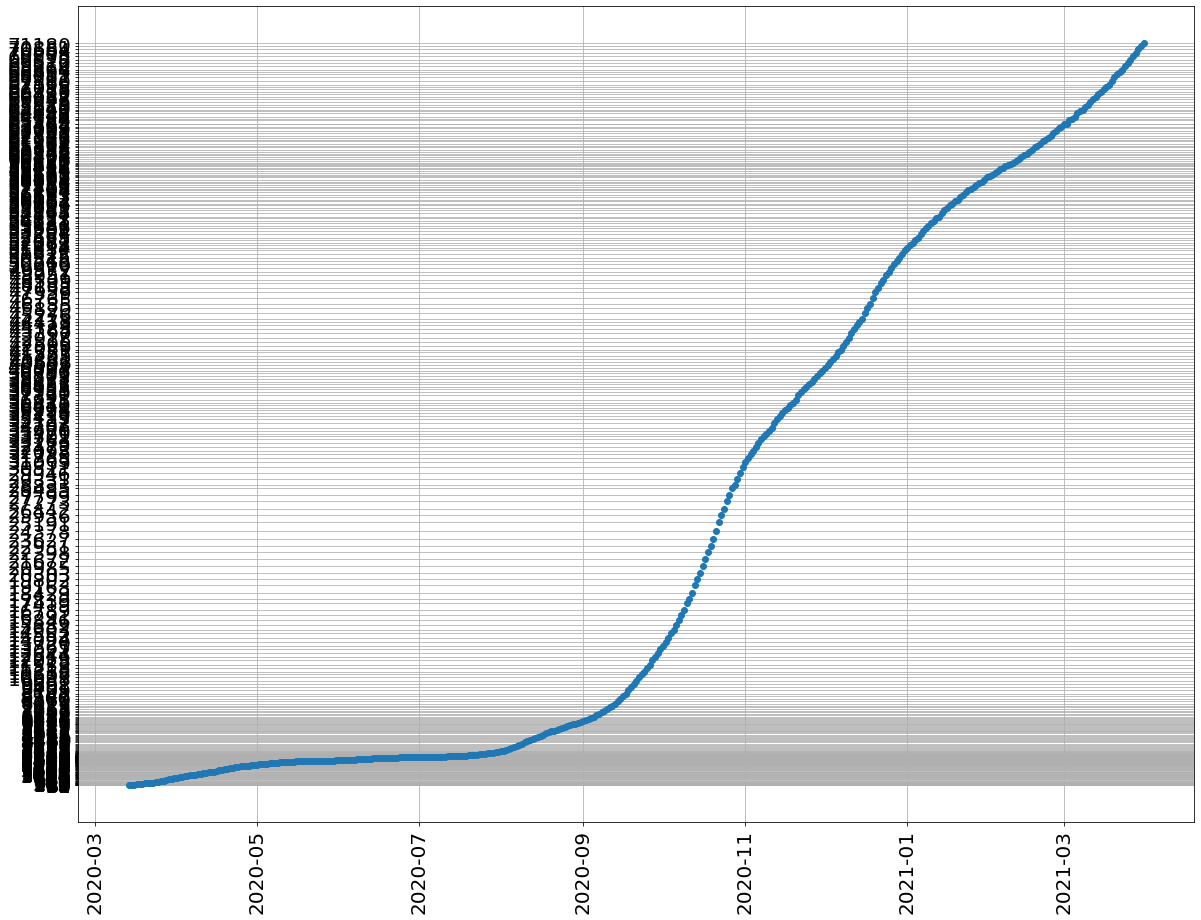

       Date_of_report  Total_reported
476        2020-03-14              31
843        2020-03-15              31
1210       2020-03-16              39
1577       2020-03-17              56
1944       2020-03-18              61
...               ...             ...
138962     2021-03-27           69995
139326     2021-03-28           70298
139690     2021-03-29           70664
140054     2021-03-30           70881
140418     2021-03-31           71180

[383 rows x 2 columns]


In [11]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Total_reported")

### Cumulative hospitalizations for last 30 days

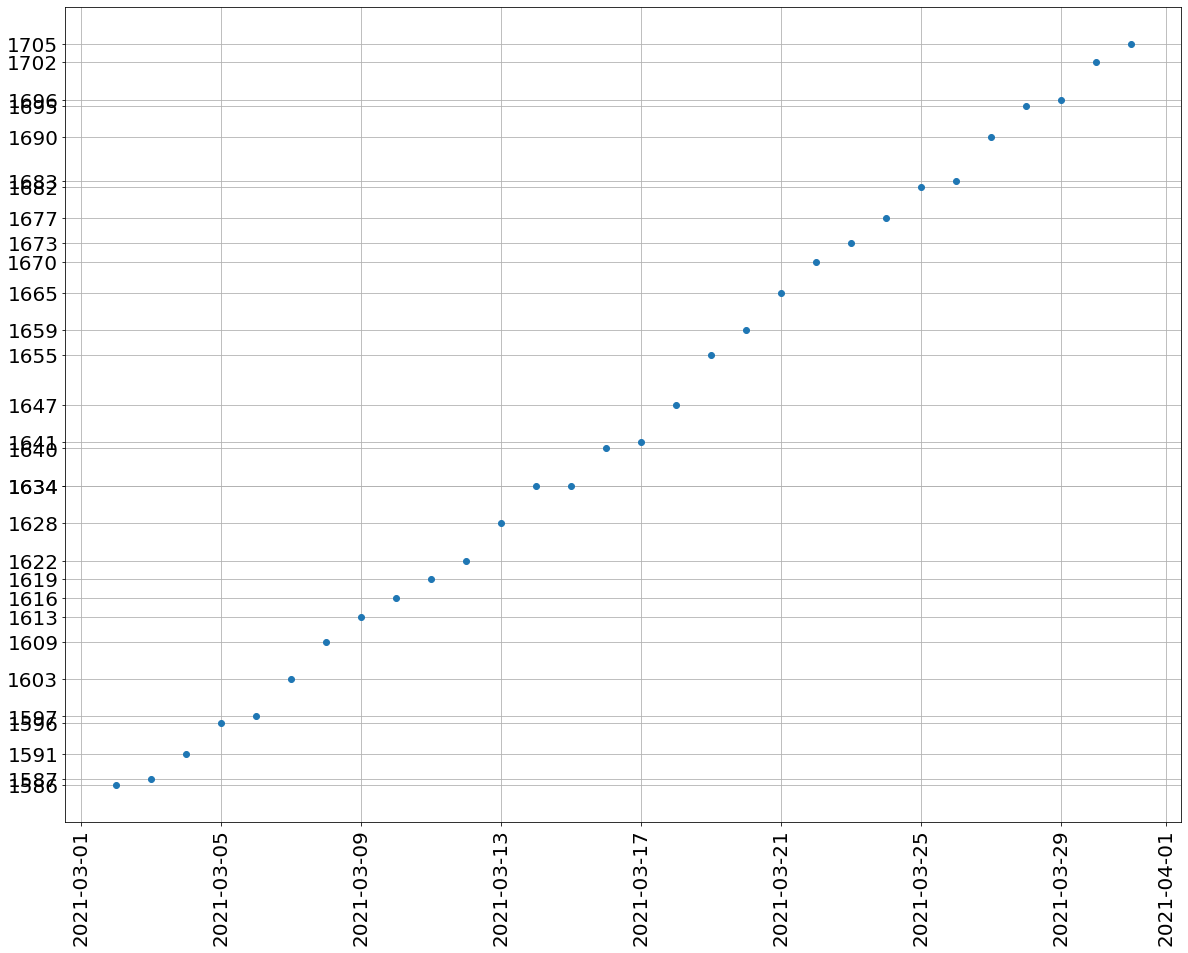

       Date_of_report  Hospital_admission
129862     2021-03-02                1586
130226     2021-03-03                1587
130590     2021-03-04                1591
130954     2021-03-05                1596
131318     2021-03-06                1597
131682     2021-03-07                1603
132046     2021-03-08                1609
132410     2021-03-09                1613
132774     2021-03-10                1616
133138     2021-03-11                1619
133502     2021-03-12                1622
133866     2021-03-13                1628
134230     2021-03-14                1634
134594     2021-03-15                1634
134958     2021-03-16                1640
135322     2021-03-17                1641
135686     2021-03-18                1647
136050     2021-03-19                1655
136414     2021-03-20                1659
136778     2021-03-21                1665
137142     2021-03-22                1670
137506     2021-03-23                1673
137870     2021-03-24             

In [12]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_admission")

### Cumulative hospitalizations since beginning

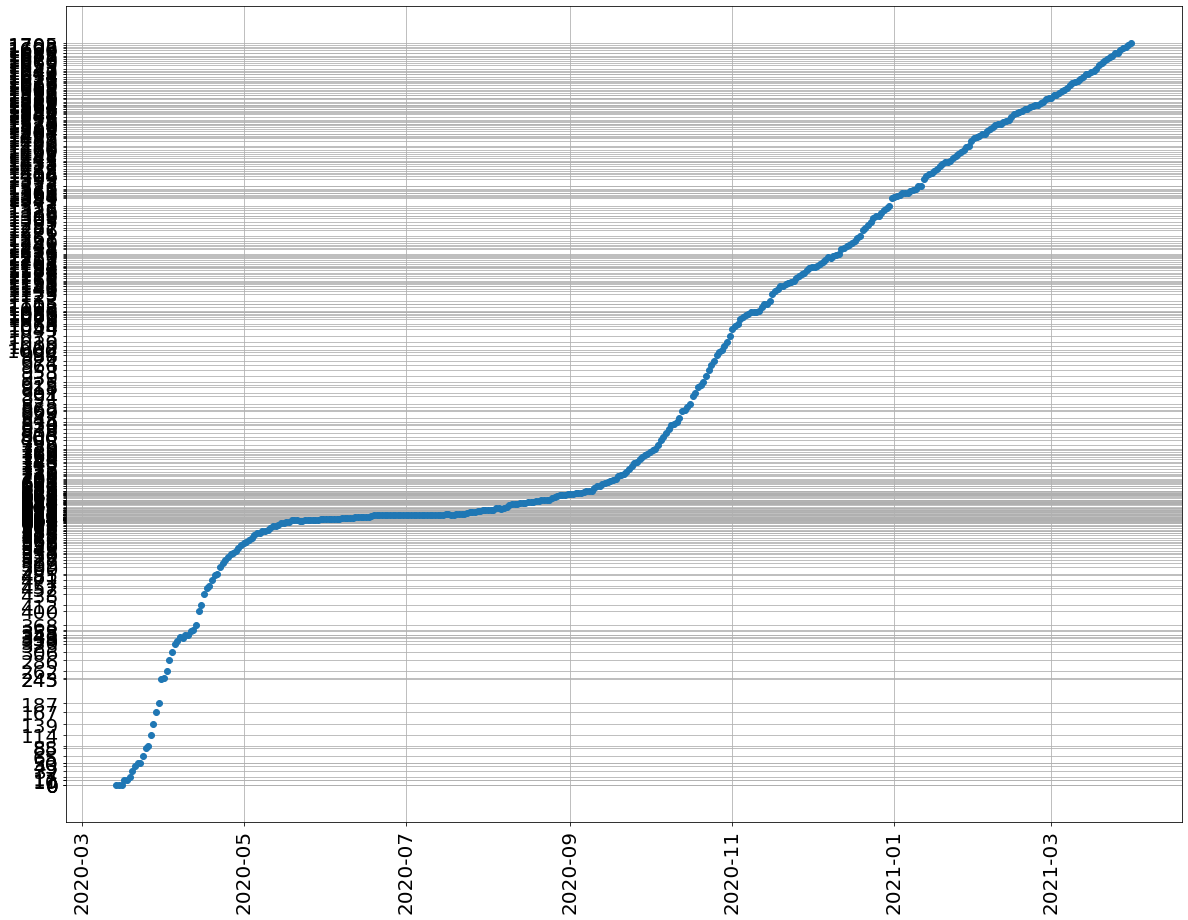

       Date_of_report  Hospital_admission
476        2020-03-14                   0
843        2020-03-15                   0
1210       2020-03-16                   0
1577       2020-03-17                  10
1944       2020-03-18                  11
...               ...                 ...
138962     2021-03-27                1690
139326     2021-03-28                1695
139690     2021-03-29                1696
140054     2021-03-30                1702
140418     2021-03-31                1705

[383 rows x 2 columns]


In [13]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Hospital_admission")

### Cumulative deaths since beginning

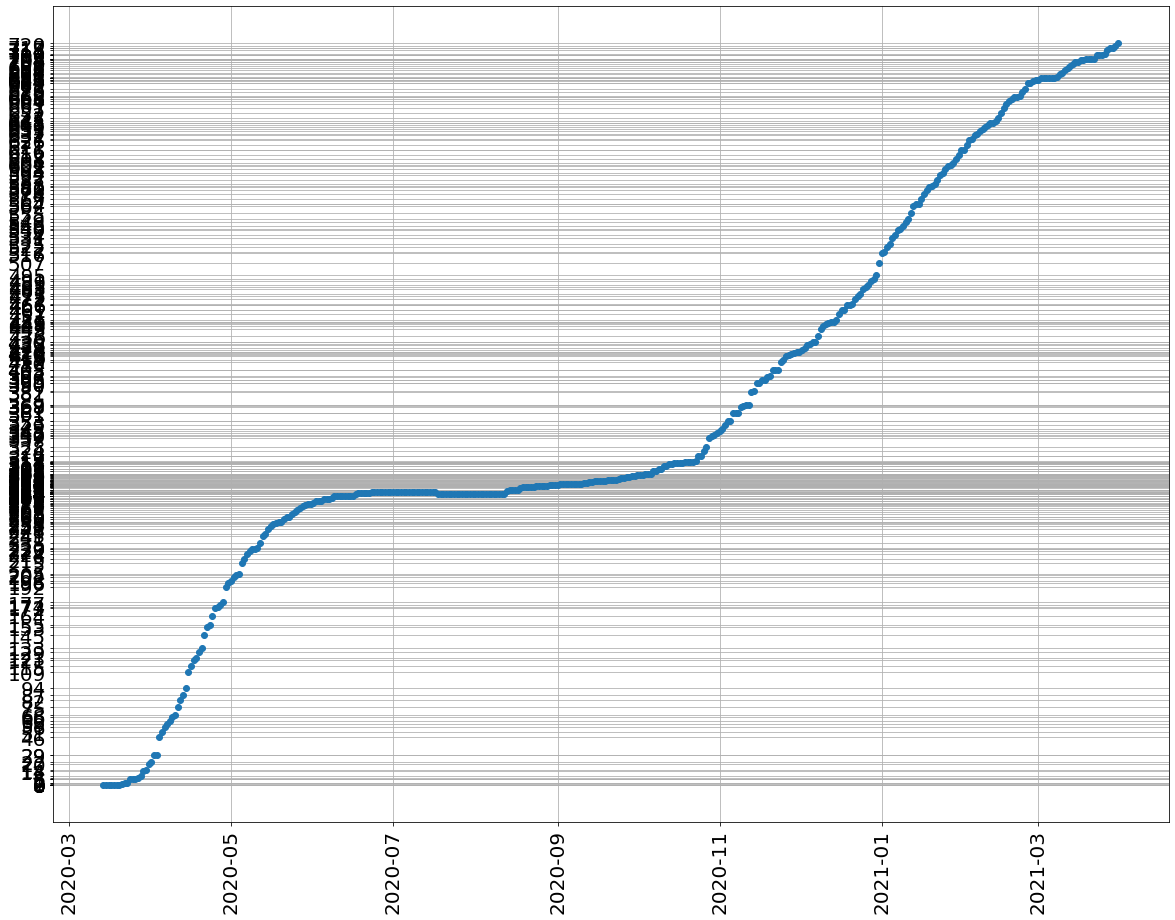

       Date_of_report  Deceased
476        2020-03-14         0
843        2020-03-15         0
1210       2020-03-16         0
1577       2020-03-17         0
1944       2020-03-18         0
...               ...       ...
138962     2021-03-27       714
139326     2021-03-28       715
139690     2021-03-29       715
140054     2021-03-30       717
140418     2021-03-31       720

[383 rows x 2 columns]


In [14]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Deceased")